## 1. Outline 

1. Load the dataset and visualise
2. add batchnorm layers
3. Comparison with and without batch normalization layers
4. Add Dropout layer
5. Comparison with and without dropout layers

In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np

import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import torchvision.models as models

from tqdm import tqdm_notebook


## 2. Dataset and visualization

In [0]:
dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform = transforms.ToTensor())
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform = transforms.ToTensor())
batch_size = 512
trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

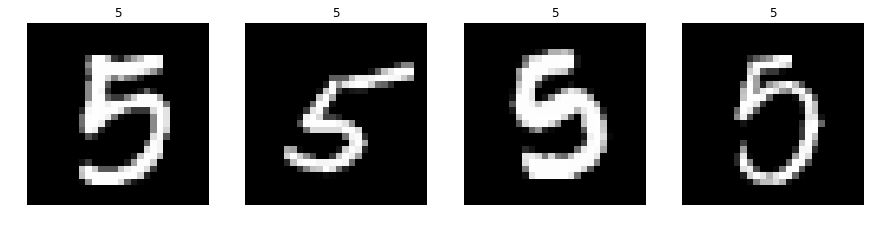

In [30]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

def show_batch_images(dataloader, no_images=4):
  images,labels = iter(dataloader).next()
  plt.figure(figsize=(15,10))
  
  for i, (img,label) in enumerate(zip(images[0:no_images],labels[0:no_images])):
    img = np.transpose(img.numpy(), (1,2,0))
    ax = plt.subplot(1,no_images,i+1)
    ax.imshow(img.reshape(img.shape[0],img.shape[1]), cmap='Greys_r')
    ax.set_title(label.item())
    ax.axis('off')
 
  plt.show()
  
show_batch_images(trainloader)

In [0]:
def return_accuracy(data_loader,model):
  correct = 0
  total = 0
  model.eval()
  for images,labels in data_loader:
    total += len(images)
    correct += torch.sum(torch.argmax(model(images),dim=1)==labels).item()
  return correct/total*100

## 3. Batch Normalization

In [0]:
class FCmodel(nn.Module):
  def __init__(self):
    super(FCmodel, self).__init__()
    self.classifier = nn.Sequential(
        nn.Linear(784,48),
        nn.ReLU(),
        nn.Linear(48,24),
        nn.ReLU(),
        nn.Linear(24,10)
    )
    
  def forward(self,x):
    x = x.view(x.size(0),-1) # flattening the image
    x = self.classifier(x)
    return x
  
  
class FCmodel_BN(nn.Module):
  def __init__(self):
    super(FCmodel_BN, self).__init__()
    self.classifier = nn.Sequential(
        nn.Linear(784,48),
        nn.BatchNorm1d(48),
        nn.ReLU(),
        nn.Linear(48,24),
        nn.BatchNorm1d(24),
        nn.ReLU(),
        nn.Linear(24,10)
    )
    
  def forward(self,x):
    x = x.view(x.size(0),-1) # flattening the image
    x = self.classifier(x)
    return x

In [6]:
model1 = FCmodel()
model2 = FCmodel_BN()

print(model1)
print(model2)

FCmodel(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=10, bias=True)
  )
)
FCmodel_BN(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=48, out_features=24, bias=True)
    (4): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=24, out_features=10, bias=True)
  )
)


**Note**: Batch normalization is continously computing the mean and standard deviation and find the right normalization for each feature at 2 layers in this case

In [0]:
loss_fn = nn.CrossEntropyLoss()
opt1 = optim.SGD(model1.parameters(), lr=0.01)
opt2 = optim.SGD(model2.parameters(), lr=0.01)

find out how many batches are loaded at every epoch

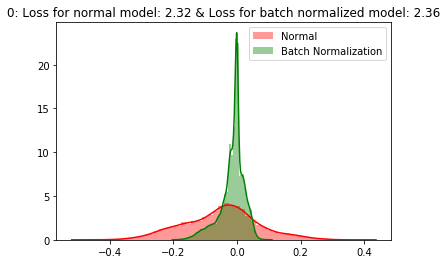

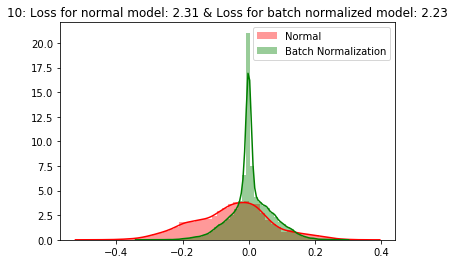

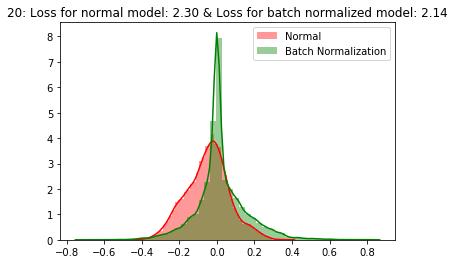

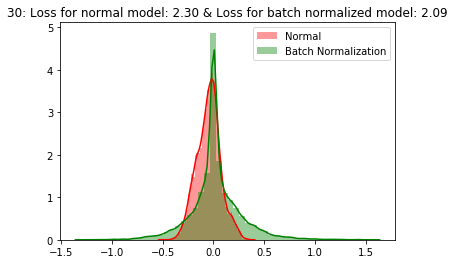

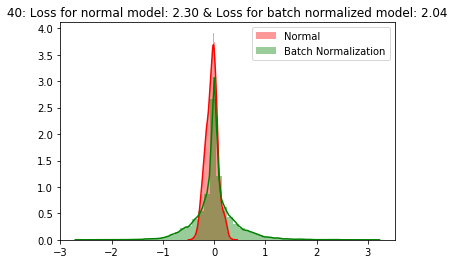

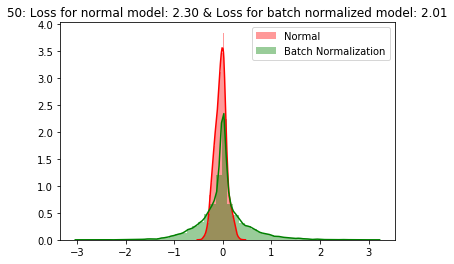

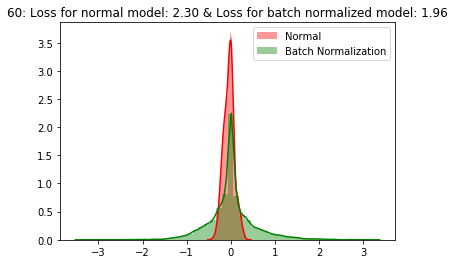

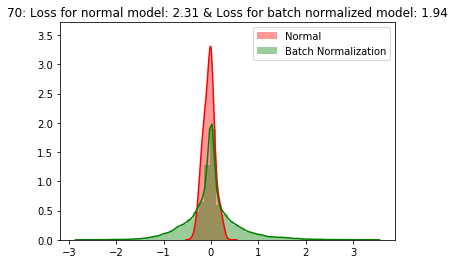

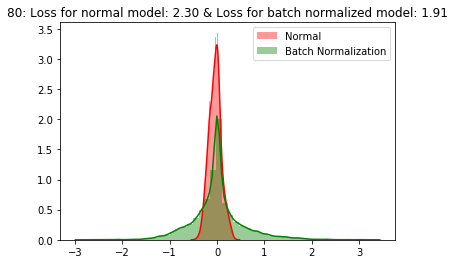

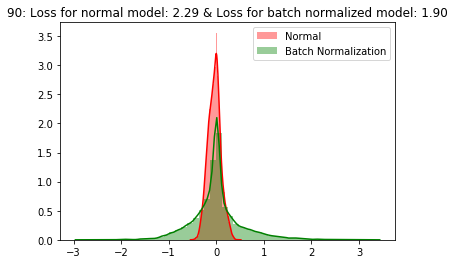

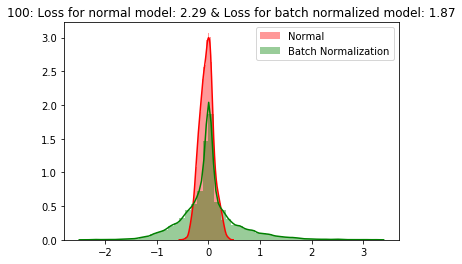

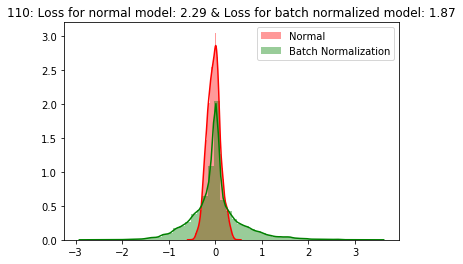

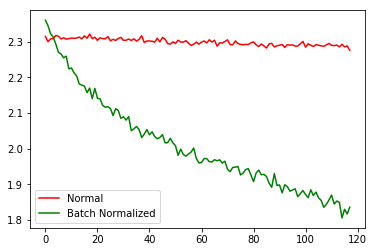

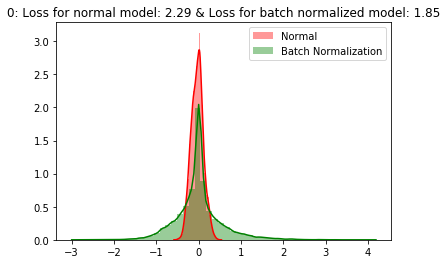

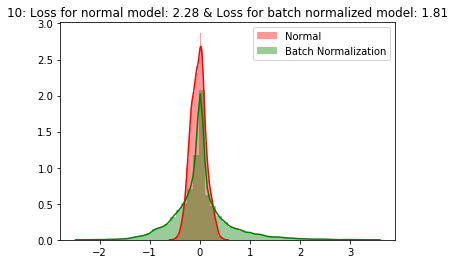

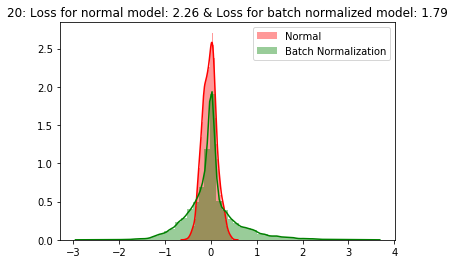

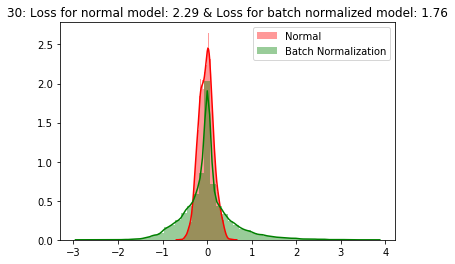

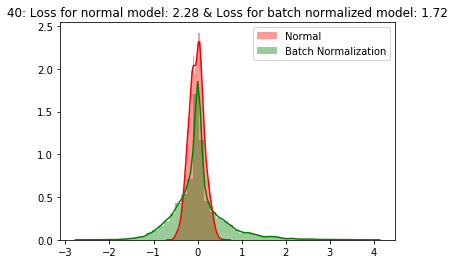

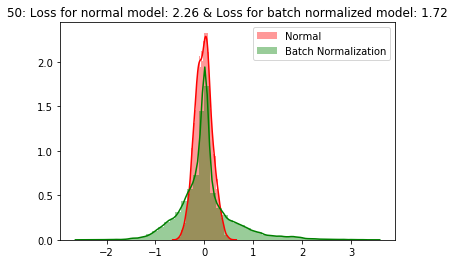

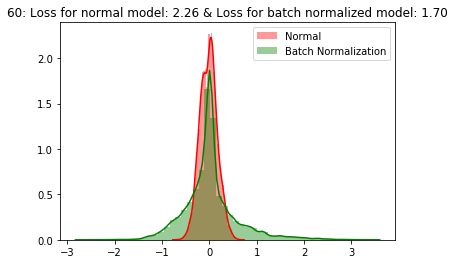

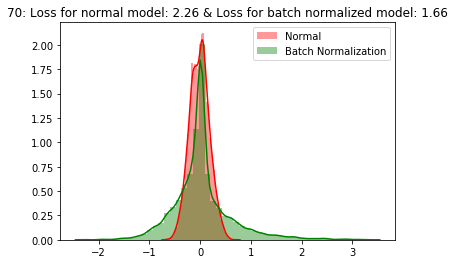

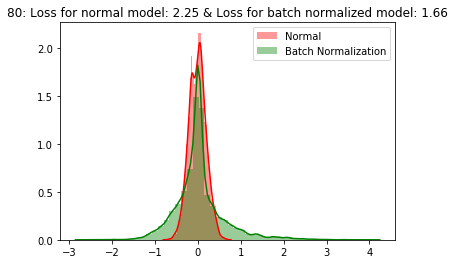

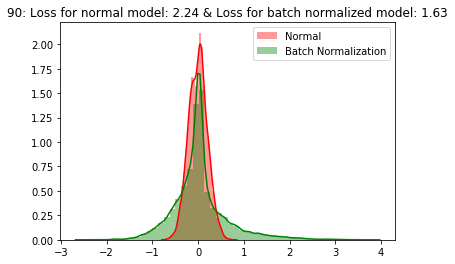

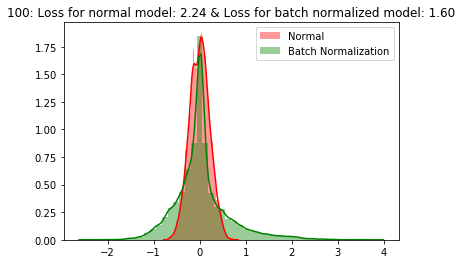

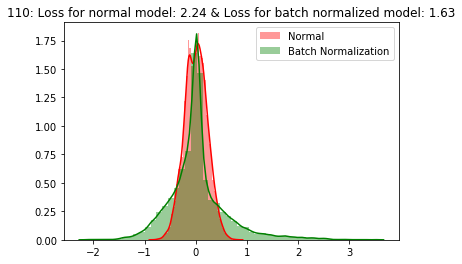

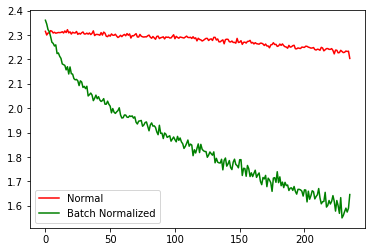

CPU times: user 28 s, sys: 4.78 s, total: 32.8 s
Wall time: 39.7 s


In [8]:
%%time 

max_epochs = 2

loss_arr = []
loss_arr_bn = []

for _ in range(max_epochs):
  
  for i, (images,labels) in tqdm_notebook(enumerate(trainloader),unit='batch ',total=len(dataset)//batch_size):
       
    # training the fully connected model
    opt1.zero_grad()
    outputs = model1(images)
    
    loss = loss_fn(outputs, labels)
    loss.backward()
    opt1.step()
    
    # training the batch normalization model
    
    opt2.zero_grad()
    outputs_bn = model2(images)
    loss_bn = loss_fn(outputs_bn,labels)
    loss_bn.backward()
    opt2.step()
    
    loss_arr.append(loss.item())
    loss_arr_bn.append(loss_bn.item())
    
    if i % 10 == 0:
      inputs = images.view(images.size(0),-1)
      model1.eval()
      model2.eval()
      
      # visualizing the outputs of the hidden layer 
      a = model1.classifier[0](inputs)
      a = model1.classifier[1](a)
      a = model1.classifier[2](a)
      a = a.detach().numpy().ravel()
      sns.distplot(a, kde=True, color='r', label='Normal')
      
      b = model2.classifier[0](inputs)
      b = model2.classifier[1](b)
      b = model2.classifier[2](b)
      b = model2.classifier[3](b)
      b = model2.classifier[4](b)
      b = b.detach().numpy().ravel()
      sns.distplot(b, kde=True, color='g', label='Batch Normalization')
      plt.title('%d: Loss for normal model: %.2f & Loss for batch normalized model: %.2f' % (i,loss.item(),loss_bn.item()) )
      plt.legend()
      model1.train()
      model2.train()
      plt.show()
      plt.pause(0.5)
      
  print('================================================')
  plt.plot(loss_arr,'r',label='Normal')
  plt.plot(loss_arr_bn,'g',label='Batch Normalized')
  plt.legend()
  plt.show()

**Observation:**
1. The distribution of the 2nd layer is shrinking compared to the batch normalized 2nd layer which has a fairly well distribution. with batch normalization at every weight update the distribution remains fairly within a range whereas for the normal case without batch normalization, the distribution changes quite abruptly.
2.  Also the loss is decreasing more for the batch normalized case

## 4. 2D Batch Normalization

Similarly compare the results of 2d CNN model with batch normalization and without it.

In [0]:
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet,self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(1,6,5),
        nn.ReLU(),
        nn.AvgPool2d(2,2),
        nn.Conv2d(6,16,5,stride=1,padding=0),
        nn.ReLU(),
        nn.AvgPool2d(2,2)
    )
    
    self.fcc = nn.Sequential(
        nn.Linear(256,120),
        nn.ReLU(),
        nn.Linear(120,84),
        nn.ReLU(),
        nn.Linear(84,10)
    )
    
  def forward(self,x):
    x = self.conv(x)
    x = x.view(x.size(0),-1) # Flattening the image for feeding it to Fully connected neural network
    x = self.fcc(x)
    return x
  
class LeNet_BN(nn.Module):
  def __init__(self):
    super(LeNet_BN,self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(1,6,5),
        nn.BatchNorm2d(6),
        nn.ReLU(),
        nn.AvgPool2d(2,2),
        nn.Conv2d(6,16,5,stride=1,padding=0),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.AvgPool2d(2,2)
    )
    
    self.fcc = nn.Sequential(
        nn.Linear(256,120),
        nn.ReLU(),
        nn.Linear(120,84),
        nn.ReLU(),
        nn.Linear(84,10)
    )
    
  def forward(self,x):
    x = self.conv(x)
    x = x.view(x.size(0),-1) # Flattening the image for feeding it to Fully connected neural network
    x = self.fcc(x)
    return x

In [78]:
model_CNN = LeNet()
print(model_CNN)

model_CNN_BN = LeNet_BN()
print(model_CNN_BN)

LeNet(
  (conv): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fcc): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)
LeNet_BN(
  (conv): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
  

### 4.1 Visualizing the ouptut of a particular hidden layer of each models and comparing them

In [0]:
loss_fn = nn.CrossEntropyLoss()
opt_cnn = optim.SGD(model_CNN.parameters(), lr=1)
opt_cnn_bn = optim.SGD(model_CNN_BN.parameters(), lr=1)

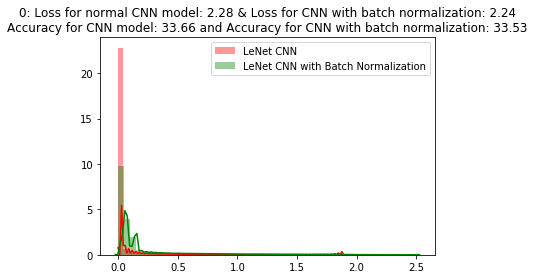

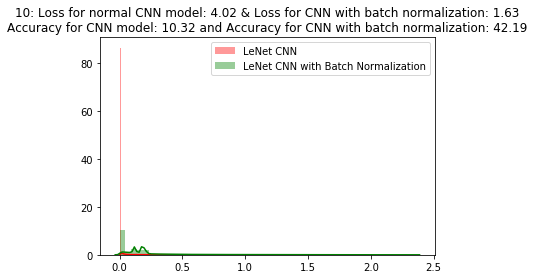

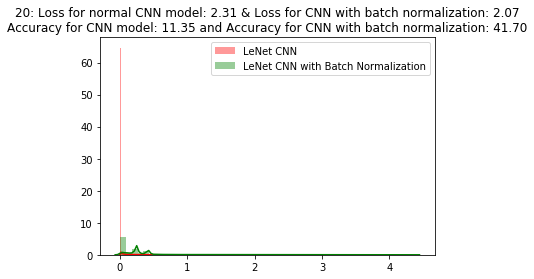

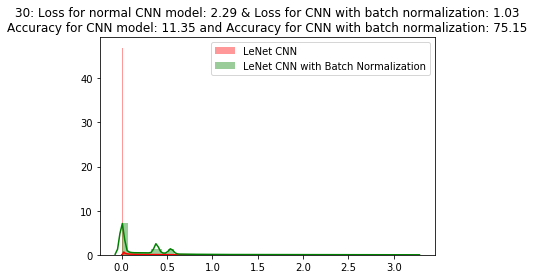

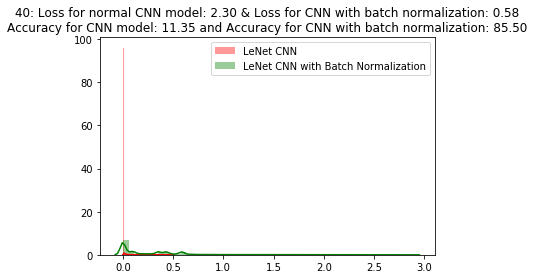

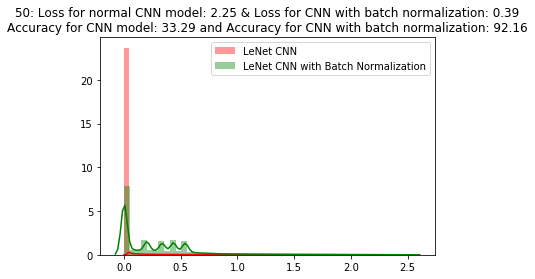

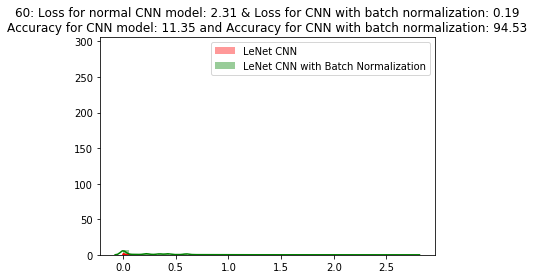

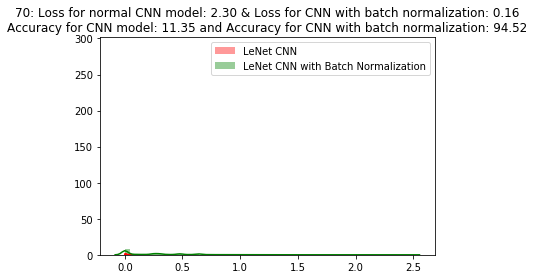

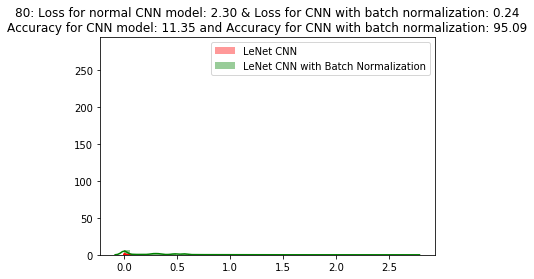

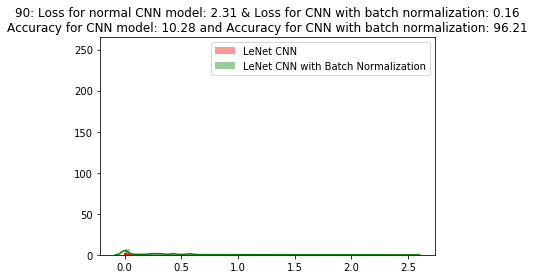

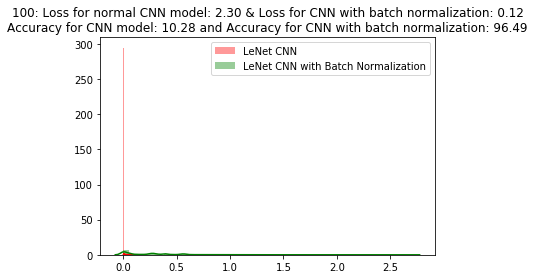

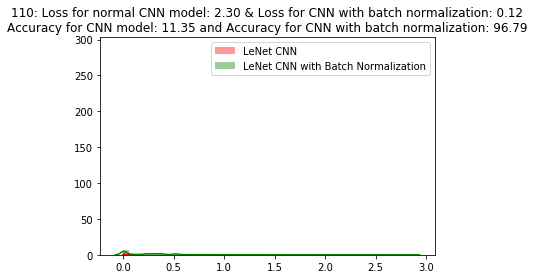

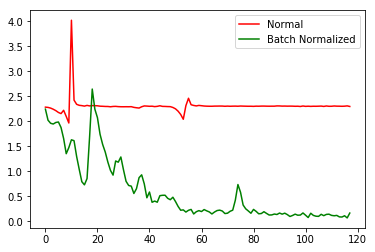

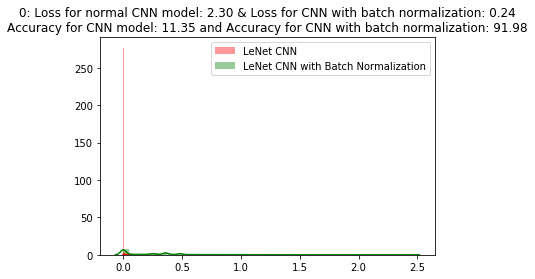

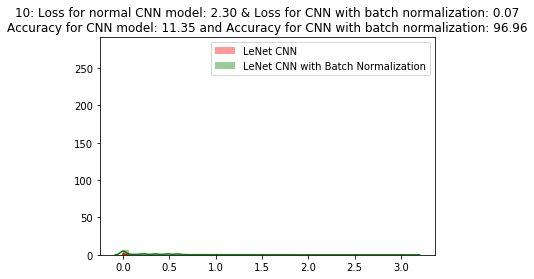

In [0]:
%%time 

max_epochs = 2

loss_arr = []
loss_arr_bn = []

for _ in range(max_epochs):  
  for i, (images,labels) in tqdm_notebook(enumerate(trainloader),unit='batch ',total=len(dataset)//batch_size):      
       
    #train the normal lenet model
    pred = model_CNN(images)
    loss = loss_fn(pred,labels)
    loss_arr.append(loss.data.item())
    loss.backward()
    opt_cnn.step()
    opt_cnn.zero_grad()
    
    # train the lenet model with batch normalization
    pred_bn = model_CNN_BN(images)
    loss_bn = loss_fn(pred_bn,labels)
    loss_arr_bn.append(loss_bn.data.item())
    loss_bn.backward()
    opt_cnn_bn.step()
    opt_cnn_bn.zero_grad()
    
    
    # visualizing the output of the hidden layer
    if i % 10 == 0:
      # set the model to eval mode
      model_CNN.eval()
      model_CNN_BN.eval()
      
      a = model_CNN.conv[0](images)
      a = model_CNN.conv[1](a)
      a = model_CNN.conv[2](a)
      a = a.detach().numpy().ravel()
      sns.distplot(a, kde=True, color='r', label='LeNet CNN')
      acc_cnn = return_accuracy(testloader, model_CNN)
      
      b = model_CNN_BN.conv[0](images)
      b = model_CNN_BN.conv[1](b)
      b = model_CNN_BN.conv[2](b)
      b = model_CNN_BN.conv[3](b)
      b = b.detach().numpy().ravel()
      sns.distplot(b, kde=True, color='g', label='LeNet CNN with Batch Normalization')
      acc_cnn_bn = return_accuracy(testloader, model_CNN_BN)
            
      plt.title('%d: Loss for normal CNN model: %.2f & Loss for CNN with batch normalization: %.2f\nAccuracy for CNN model: %.2f and Accuracy for CNN with batch normalization: %.2f' % (i,loss.item(),loss_bn.item(), acc_cnn, acc_cnn_bn) )
      plt.legend()
      model_CNN.train()
      model_CNN_BN.train()
      plt.show()
      plt.pause(0.5)
      
  print('================================================')
  plt.plot(loss_arr,'r',label='Normal')
  plt.plot(loss_arr_bn,'g',label='Batch Normalized')
  plt.legend()
  plt.show()

We can see that batch normalization plays an important role in keeping the weights under a certain range so the model can learn the data efficiently and brings down the loss significantly.

## 5. Dropout

**this needs to be reviewed**

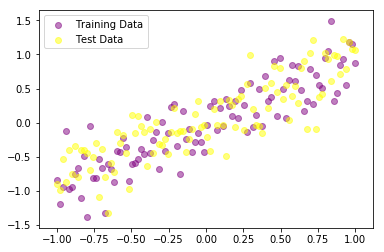

In [13]:
N = 100
noise = 0.3

X_train = torch.unsqueeze(torch.linspace(-1,1,N),1)
Y_train = X_train + noise*torch.normal(torch.zeros(N,1), torch.ones(N,1))

X_test = torch.unsqueeze(torch.linspace(-1,1,N),1)
Y_test = X_test + noise*torch.normal(torch.zeros(N,1), torch.ones(N,1))


plt.scatter(X_train.data.numpy(), Y_train.data.numpy(), c='purple', label='Training Data', alpha=0.5)
plt.scatter(X_test.data.numpy(), Y_test.data.numpy(), c='yellow', label='Test Data', alpha=0.5)
plt.legend()
plt.show()

In [0]:
# models 
N_h = 100

class FCmodel_no_drop(nn.Module):
  def __init__(self):
    super(FCmodel_no_drop, self).__init__()
    self.classifier = nn.Sequential(
        nn.Linear(1,N_h),
        nn.ReLU(),
        nn.Linear(N_h,N_h),
        nn.ReLU(),
        nn.Linear(N_h,1)
    )
    
  def forward(self,x):
    x = self.classifier(x)
    return x
  
class FCmodel_drop(nn.Module):
  def __init__(self):
    super(FCmodel_drop, self).__init__()
    self.classifier = nn.Sequential(
        nn.Linear(1,N_h),
        nn.Dropout(0.5),
        nn.ReLU(),
        nn.Linear(N_h,N_h),
        nn.Dropout(0.5),
        nn.ReLU(),
        nn.Linear(N_h,1)
    )
    
  def forward(self,x):
    x = self.classifier(x)
    return x

In [0]:
model3 = FCmodel_no_drop()
model4 = FCmodel_drop()

opt = optim.Adam(model3.parameters(), lr=0.01)
opt_dropout = optim.Adam(model4.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

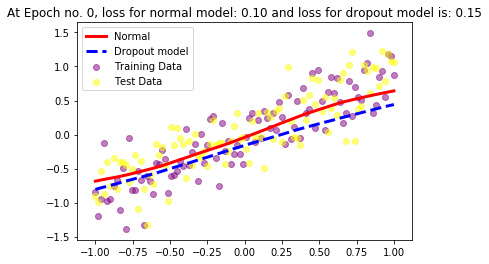

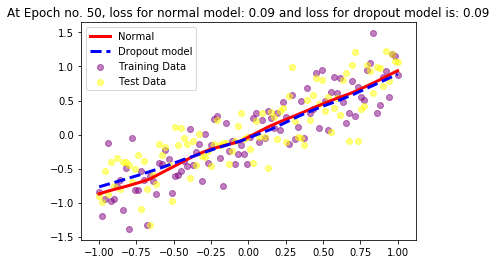

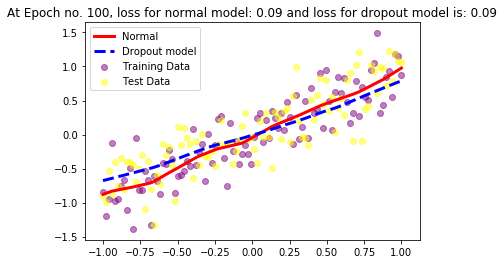

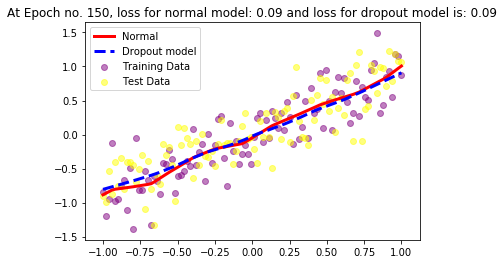

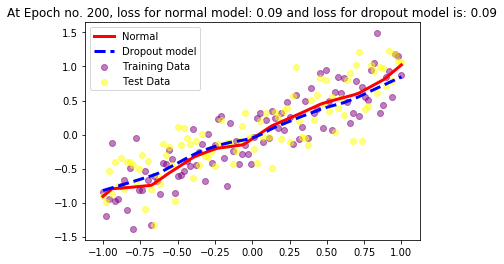

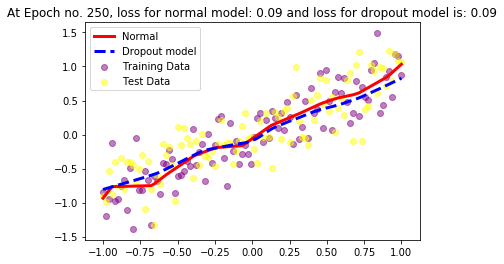

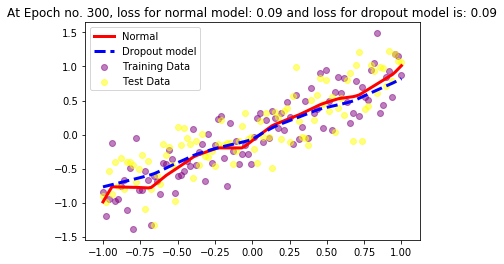

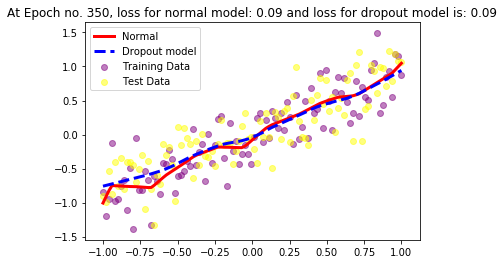

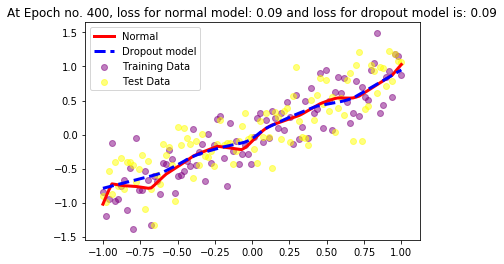

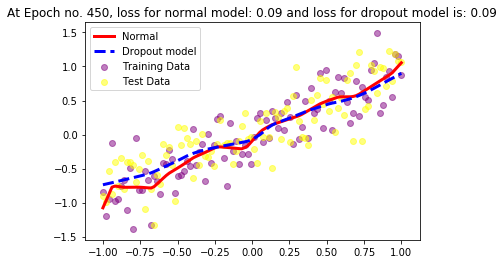

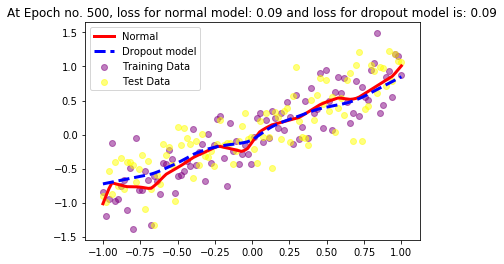

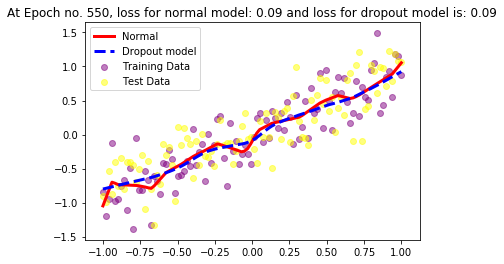

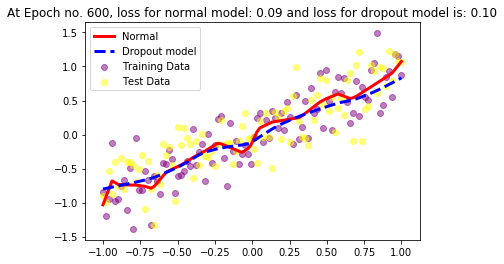

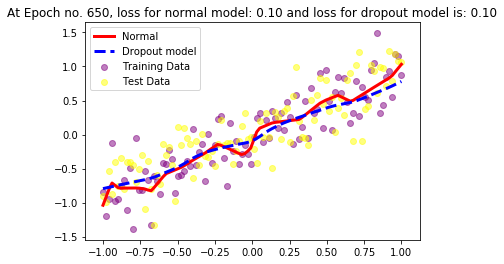

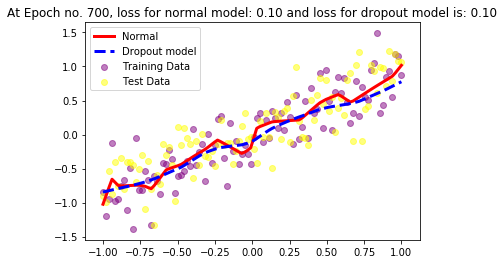

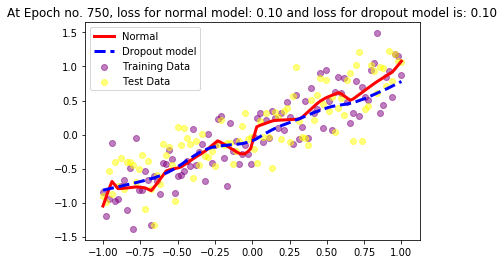

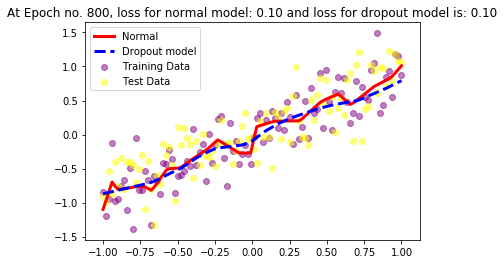

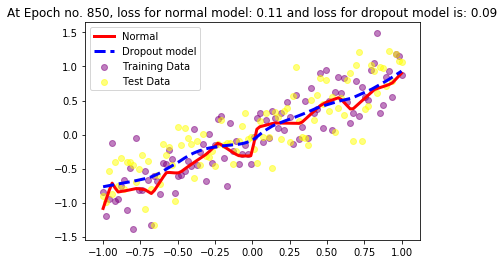

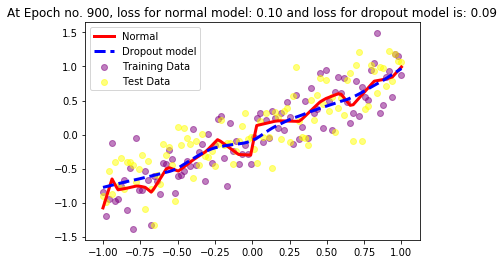

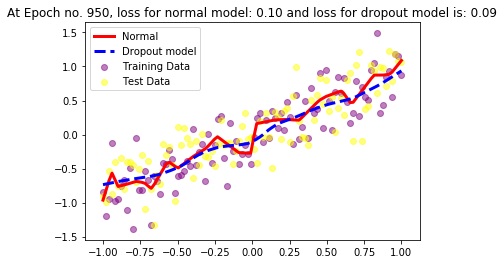

In [16]:
max_epochs = 1000

for i in range(max_epochs):
  
  # training the model without dropout
  pred = model3(X_train)
  loss = loss_fn(pred,Y_train)
  loss.backward()
  opt.step()
  opt.zero_grad()
  
  # training the model with dropout
  pred_dropout = model4(X_train)
  loss_dropout = loss_fn(pred_dropout, Y_train)
  loss_dropout.backward()
  opt_dropout.step()
  opt_dropout.zero_grad()
  
  if i % 50 == 0:
    
    # put the models in non-trianing mode i.e. the evaluation mode
    model3.eval()
    model4.eval()
    
    test_pred = model3(X_test)
    test_pred_dropout = model4(X_test)
    
    test_loss = loss_fn(test_pred, Y_test)
    test_loss_dropout = loss_fn(test_pred_dropout,Y_test)
    
    plt.scatter(X_train.data.numpy(), Y_train.data.numpy(), c='purple', label='Training Data', alpha=0.5)
    plt.scatter(X_test.data.numpy(), Y_test.data.numpy(), c='yellow', label='Test Data', alpha=0.5)
    plt.plot(X_test.data.numpy(), test_pred.data.numpy(), 'r-', lw=3, label='Normal')
    plt.plot(X_test.data.numpy(), test_pred_dropout.data.numpy(), 'b--', lw=3, label='Dropout model')
    plt.title('At Epoch no. %d, loss for normal model: %.2f and loss for dropout model is: %.2f'% (i, test_loss.item(), test_loss_dropout.item()))
    plt.legend()
    
    # put the models in training mode after visualization of the test data
    model3.train()
    model4.train()
    
    plt.pause(0.05)
    
    plt.show()

We can see the the dropout method helps to regularize the model and prevents the model from overfitting. Hence bringing down loss at every epoch. 

## 6. Exercises

1. Try out batch normalization for convolution 2D model and compare it to same model without batch normalization
2. Try dropout on a CNN with CIFAR10

Dropout of probability X means chances of droping neurons/parameters is X %

In [0]:
class LeNet_BN_dropout(nn.Module):
  def __init__(self):
    super(LeNet_BN_dropout,self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(1,6,5),
        nn.BatchNorm2d(6),
        nn.ReLU(),
        nn.AvgPool2d(2,2),
        nn.Conv2d(6,16,5,stride=1,padding=0),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.AvgPool2d(2,2)
    )
    
    self.fcc = nn.Sequential(
        nn.Linear(256,120),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(120,84),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(84,10)
    )
    
  def forward(self,x):
    x = self.conv(x)
    x = x.view(x.size(0),-1) # Flattening the image for feeding it to Fully connected neural network
    x = self.fcc(x)
    return x

In [74]:
model_CNN_BN_DO = LeNet_BN_dropout()
model_CNN_BN = LeNet_BN()
print(model_CNN_BN)
print(model_CNN_BN_DO)

LeNet_BN(
  (conv): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fcc): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)
LeNet_BN_dropout(
  (conv): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Conv2d(6, 16, kernel_si

In [0]:
loss_fn = nn.CrossEntropyLoss()
opt_cnn_bn_do = optim.SGD(model_CNN_BN_DO.parameters(), lr=1)
opt_cnn_bn = optim.SGD(model_CNN_BN.parameters(), lr=1)

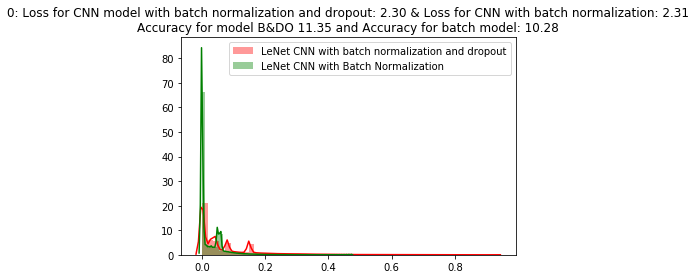

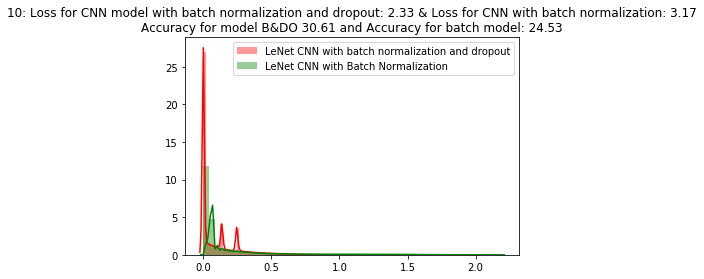

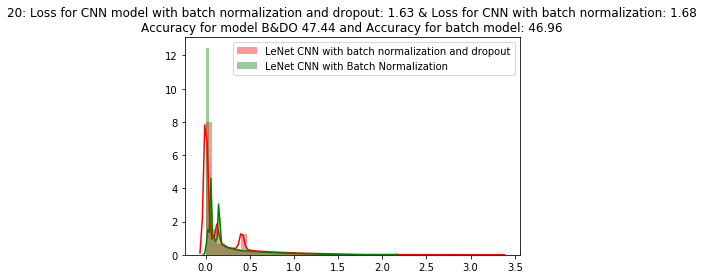

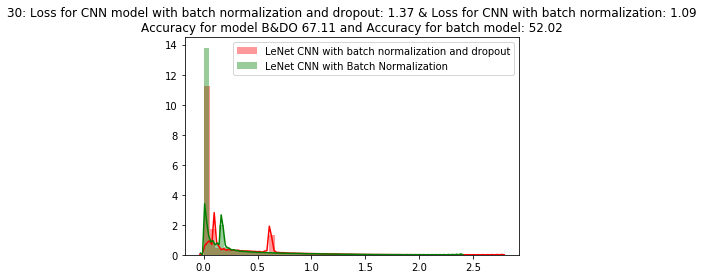

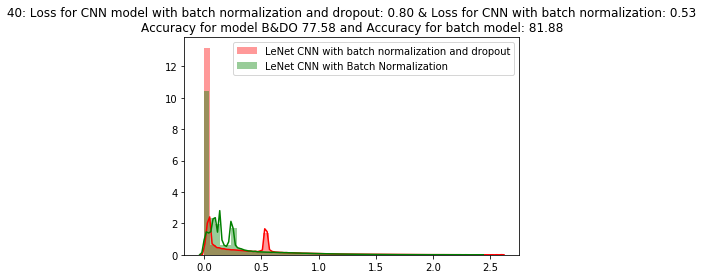

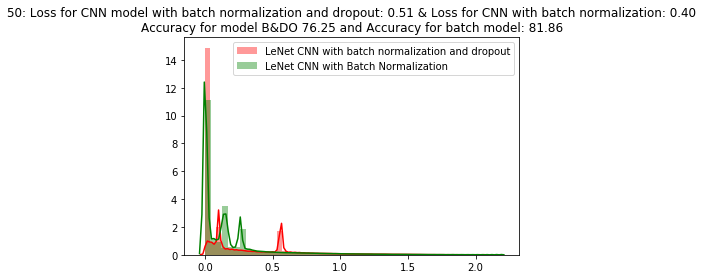

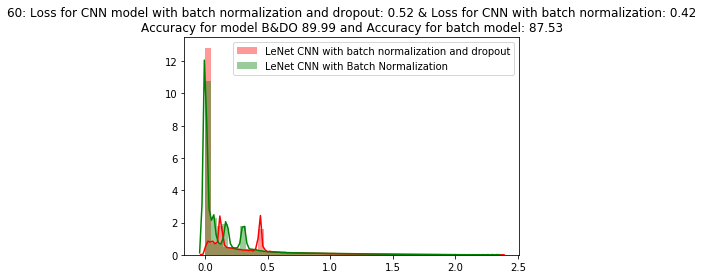

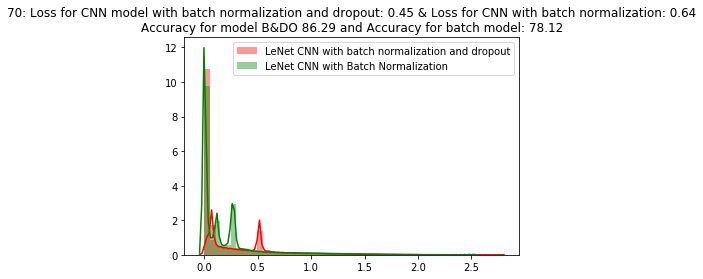

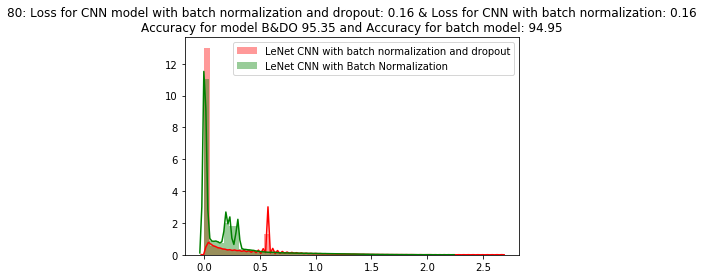

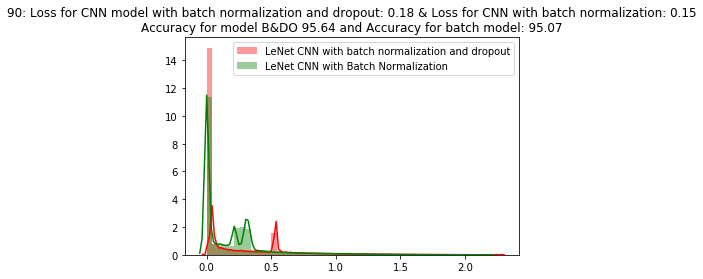

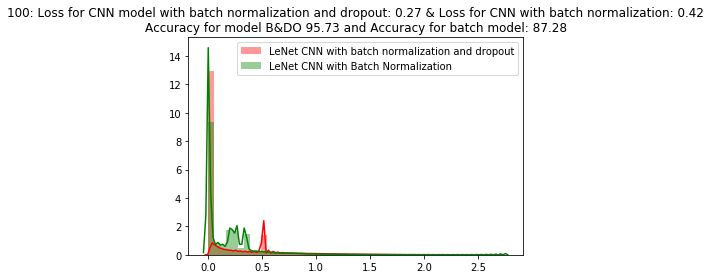

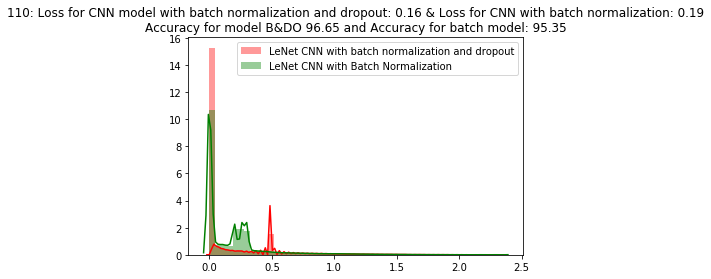

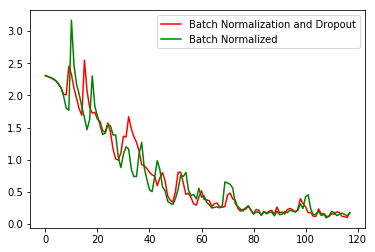

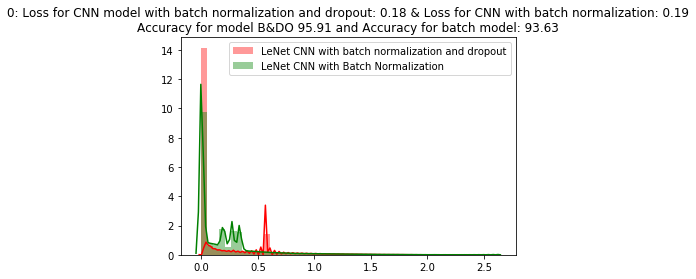

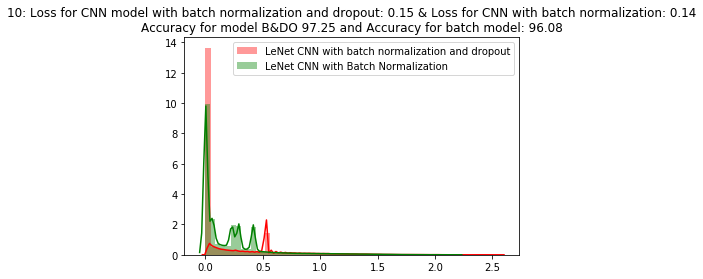

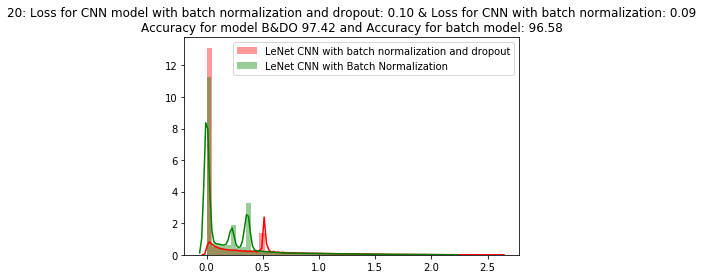

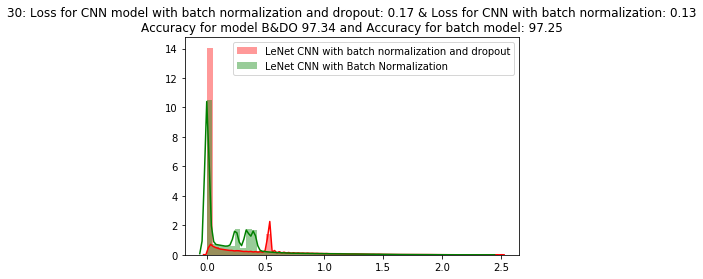

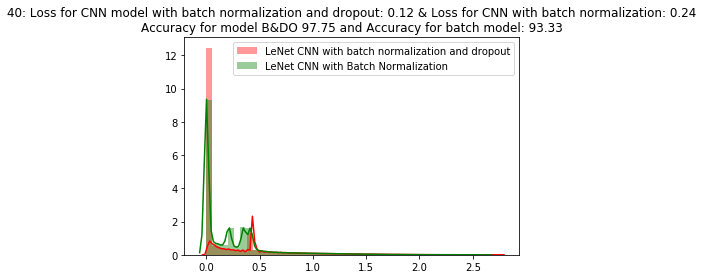

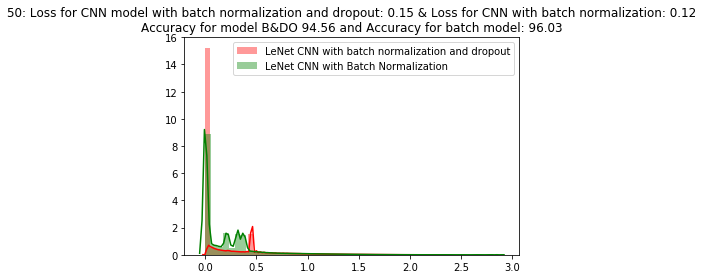

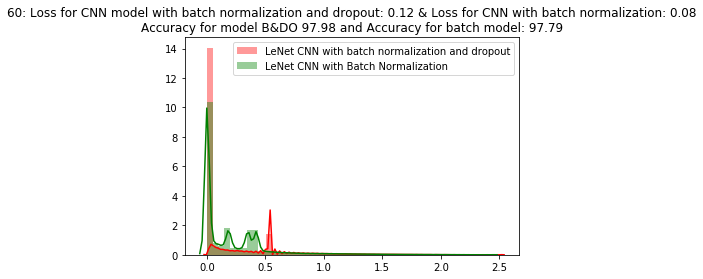

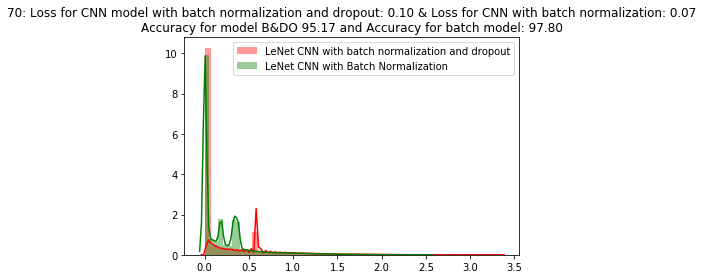

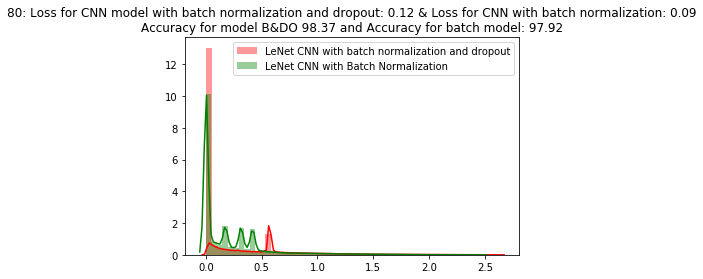

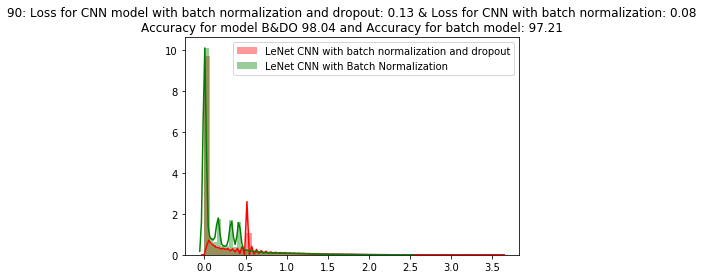

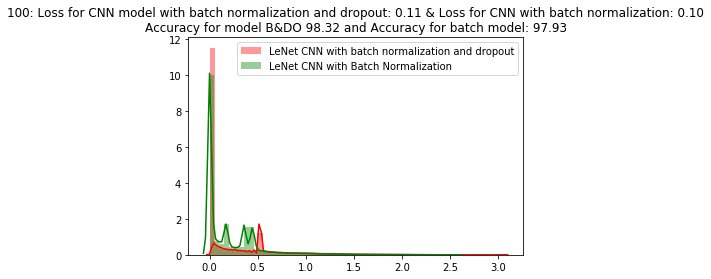

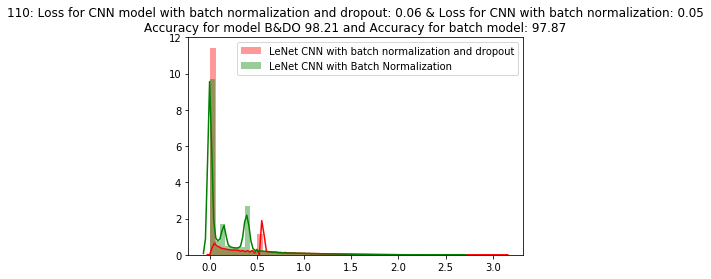

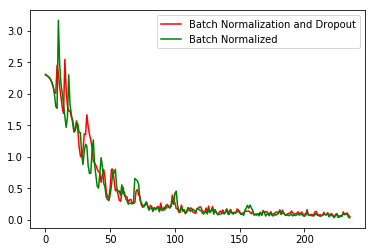

CPU times: user 3min 7s, sys: 7.42 s, total: 3min 15s
Wall time: 3min 22s


In [76]:
%%time 

max_epochs = 2

loss_arr = []
loss_arr_bn = []

for _ in range(max_epochs):  
  for i, (images,labels) in tqdm_notebook(enumerate(trainloader),unit='batch ',total=len(dataset)//batch_size):      
       
    #train the normal lenet model
    pred = model_CNN_BN_DO(images)
    loss = loss_fn(pred,labels)
    loss_arr.append(loss.data.item())
    loss.backward()
    opt_cnn_bn_do.step()
    opt_cnn_bn_do.zero_grad()
    
    # train the lenet model with batch normalization
    pred_bn = model_CNN_BN(images)
    loss_bn = loss_fn(pred_bn,labels)
    loss_arr_bn.append(loss_bn.data.item())
    loss_bn.backward()
    opt_cnn_bn.step()
    opt_cnn_bn.zero_grad()
    
    
    # visualizing the output of the hidden layer
    if i % 10 == 0:
      # set the model to eval mode
      model_CNN_BN_DO.eval()
      model_CNN_BN.eval()
      
      a = model_CNN_BN_DO.conv[0](images)
      a = model_CNN_BN_DO.conv[1](a)
      a = model_CNN_BN_DO.conv[2](a)
      a = model_CNN_BN_DO.conv[3](a)
      a = a.detach().numpy().ravel()
      sns.distplot(a, kde=True, color='r', label='LeNet CNN with batch normalization and dropout')
      acc_cnn_bn_do = return_accuracy(testloader, model_CNN_BN_DO)
      
      
      b = model_CNN_BN.conv[0](images)
      b = model_CNN_BN.conv[1](b)
      b = model_CNN_BN.conv[2](b)
      b = model_CNN_BN.conv[3](b)
      b = b.detach().numpy().ravel()
      sns.distplot(b, kde=True, color='g', label='LeNet CNN with Batch Normalization')
      acc_cnn_bn = return_accuracy(testloader, model_CNN_BN)
            
      plt.title('%d: Loss for CNN model with batch normalization and dropout: %.2f & Loss for CNN with batch normalization: %.2f\nAccuracy for model B&DO %.2f and Accuracy for batch model: %.2f' % (i,loss.item(),loss_bn.item(),acc_cnn_bn_do,acc_cnn_bn))
      plt.legend()
      model_CNN_BN_DO.train()
      model_CNN_BN.train()
      plt.show()
      plt.pause(0.5)
      
  print('================================================')
  plt.plot(loss_arr,'r',label='Batch Normalization and Dropout')
  plt.plot(loss_arr_bn,'g',label='Batch Normalized')
  plt.legend()
  plt.show()

For MNIST Data, here the model considered is very simple thats why the dropout is not working out significantly.